# Detect data bias with Amazon SageMaker Clarify

### Introduction


Bias can be present in your data before any model training occurs. Inspecting the dataset for bias can help detect collection gaps, inform your feature engineering, and understand societal biases the dataset may reflect. In this lab you will analyze bias on the dataset, generate and analyze bias report, and prepare the dataset for the model training.

### Table of Contents

- [1. Analyze the dataset](#c1w2-1.)
  - [1.1. Create a pandas data frame from the CSV file](#c1w2-1.1.)
  - [1.2. Upload the dataset to S3 bucket](#c1w2-1.2.)
- [2. Analyze class imbalance on the dataset with Amazon SageMaker Clarify](#c1w2-2.)
  - [2.1. Configure a `DataConfig`](#c1w2-2.1.)
    - [Exercise 1](#c1w2-ex-1)
  - [2.2. Configure `BiasConfig`](#c1w2-2.2.)
  - [2.3. Configure Amazon SageMaker Clarify as a processing job](#c1w2-2.3.)
  - [2.4. Run the Amazon SageMaker Clarify processing job](#c1w2-2.4.)
    - [Exercise 2](#c1w2-ex-2)
  - [2.5. Run and review the Amazon SageMaker Clarify processing job on the unbalanced dataset](#c1w2-2.5.)
  - [2.6. Analyze unbalanced bias report](#c1w2-2.6.)
- [3. Balance the dataset by `product_category` and `sentiment`](#c1w2-3.)
- [4. Analyze bias on balanced dataset with Amazon SageMaker Clarify](#c1w2-4.)
  - [4.1. Configure a `DataConfig`](#c1w2-4.1.)
    - [Exercise 3](#c1w2-ex-3)
  - [4.2. Configure `BiasConfig`](#c1w2-4.2.)
  - [4.3. Configure SageMaker Clarify as a processing job](#c1w2-4.3.)
  - [4.4. Run the Amazon SageMaker Clarify processing job](#c1w2-4.4.)
    - [Exercise 4](#c1w2-ex-4)
  - [4.5. Run and review the Clarify processing job on the balanced dataset](#c1w2-4.5.)
  - [4.6. Analyze balanced bias report](#c1w2-4.6.)

First, let's install and import required modules.

In [2]:
# please ignore warning messages during the installation
!pip install --disable-pip-version-check -q sagemaker==2.35.0

In [3]:
import boto3
import sagemaker
import pandas as pd
import numpy as np
import botocore

config = botocore.config.Config(user_agent_extra='dlai-pds/c1/w2')

# low-level service client of the boto3 session
sm = boto3.client(service_name='sagemaker', 
                  config=config)

sess = sagemaker.Session(sagemaker_client=sm)

bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
region = sess.boto_region_name

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

<a name='c1w2-1.'></a>
# 1. Analyze the dataset

<a name='c1w2-1.1.'></a>
### 1.1. Create a pandas data frame from the CSV file

Create a pandas dataframe from each of the product categories and concatenate them into one.

In [9]:
#!aws s3 cp 's3://dlai-practical-data-science/data/transformed/womens_clothing_ecommerce_reviews_transformed.csv' ./

download: s3://dlai-practical-data-science/data/transformed/womens_clothing_ecommerce_reviews_transformed.csv to ./womens_clothing_ecommerce_reviews_transformed.csv


In [4]:
path = './data/BASEAUTO.csv'
df = pd.read_csv(path, sep = ';', header=0)
df.head()

,PERMIS,ACV,SEX,STATUT,CSP,USAGE,AGECOND,K8000,RM,CAR,CLA,ALI,ENE,VIT,SEGM,CHARGE,GARAGE
0,245,10,F,C,50,2,40,N,64,BER,A,CAR,ES,130-140,A,0.0,3
1,348,10,F,A,50,1,63,N,50,BER,A,CAR,ES,001-130,0,0.0,3
2,16,10,F,C,26,2,20,N,95,BER,A,CAR,ES,001-130,0,0.0,3
3,291,10,F,A,50,1,56,N,50,BER,A,CAR,ES,001-130,0,0.0,3
4,123,10,F,A,50,1,29,N,95,BER,A,CAR,ES,140-150,B,0.0,3


In [5]:
df['target'] = df['CHARGE'].map(lambda val: 0 if val==0 else 1)
df.drop('CHARGE', axis=1, inplace=True)
df.head()

,PERMIS,ACV,SEX,STATUT,CSP,USAGE,AGECOND,K8000,RM,CAR,CLA,ALI,ENE,VIT,SEGM,GARAGE,target
0,245,10,F,C,50,2,40,N,64,BER,A,CAR,ES,130-140,A,3,0
1,348,10,F,A,50,1,63,N,50,BER,A,CAR,ES,001-130,0,3,0
2,16,10,F,C,26,2,20,N,95,BER,A,CAR,ES,001-130,0,3,0
3,291,10,F,A,50,1,56,N,50,BER,A,CAR,ES,001-130,0,3,0
4,123,10,F,A,50,1,29,N,95,BER,A,CAR,ES,140-150,B,3,0


In [6]:
path_unbalanced = './data/BASEAUTO_unbalanced.csv'
df.to_csv(path_unbalanced, index=False, header=True)

In [7]:
df.head()

,PERMIS,ACV,SEX,STATUT,CSP,USAGE,AGECOND,K8000,RM,CAR,CLA,ALI,ENE,VIT,SEGM,GARAGE,target
0,245,10,F,C,50,2,40,N,64,BER,A,CAR,ES,130-140,A,3,0
1,348,10,F,A,50,1,63,N,50,BER,A,CAR,ES,001-130,0,3,0
2,16,10,F,C,26,2,20,N,95,BER,A,CAR,ES,001-130,0,3,0
3,291,10,F,A,50,1,56,N,50,BER,A,CAR,ES,001-130,0,3,0
4,123,10,F,A,50,1,29,N,95,BER,A,CAR,ES,140-150,B,3,0


As you saw in the previous lab, there are way more positive reviews than negative or neutral. Such a dataset is called unbalanced. 

In this case, using a relatively small data subset you could visualize the occurring unbalances. At scale, you would need to perform bias analysis. Let's use this dataset as an example.

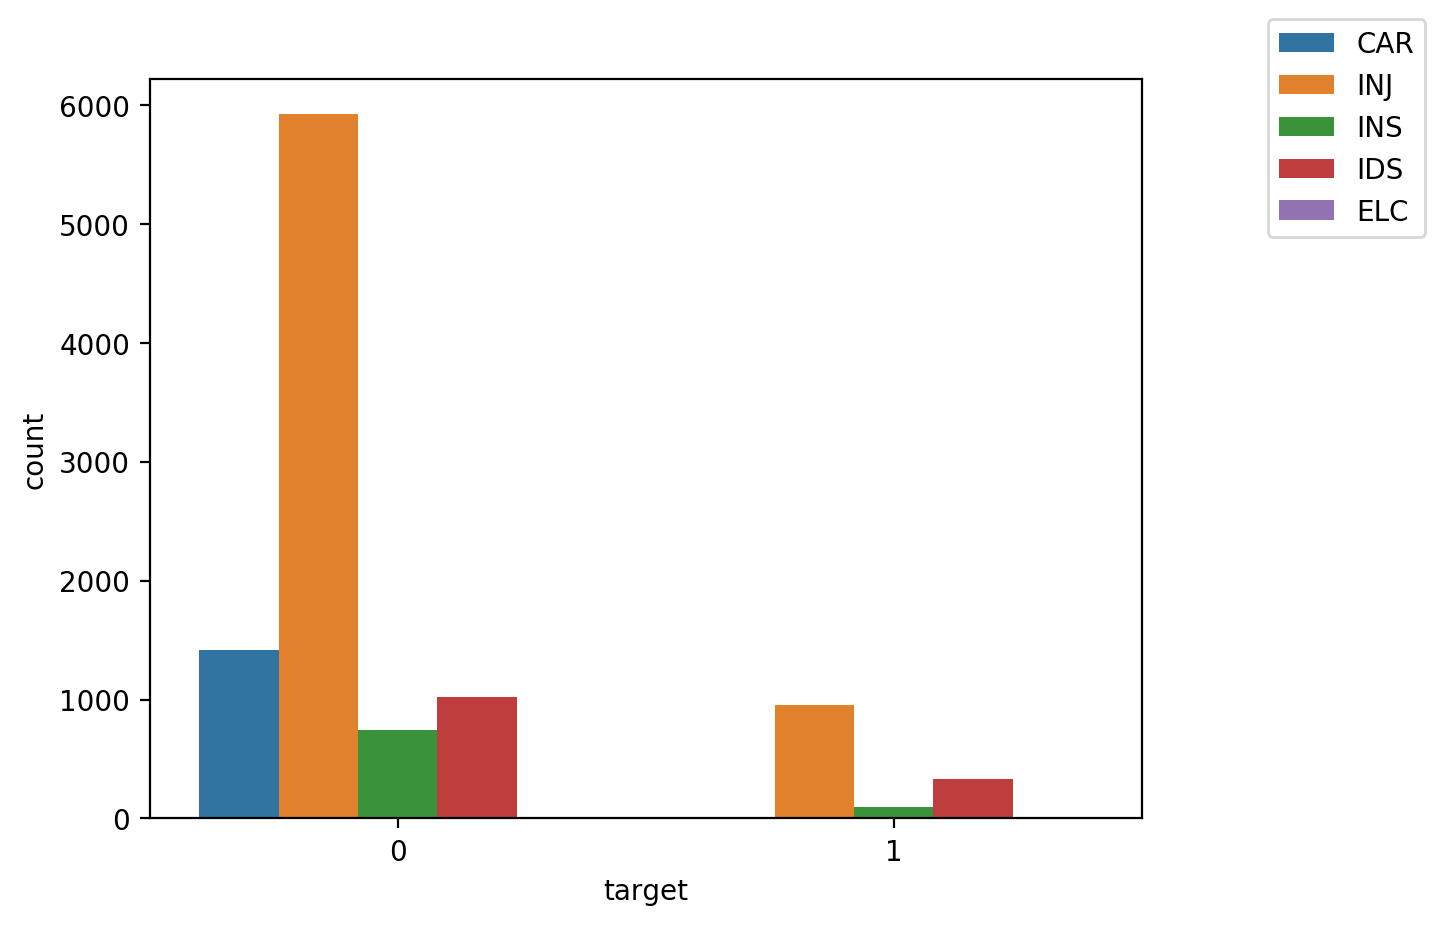

In [11]:
import seaborn as sns

sns.countplot(data=df, x='target', hue='ALI')

plt.legend(loc='upper right',bbox_to_anchor=(1.3, 1.1));

<a name='c1w2-1.2.'></a>
### 1.2. Upload the dataset to S3 bucket

Upload the dataset to a private S3 bucket in a folder called `bias/unbalanced`.

In [12]:
data_s3_uri_unbalanced = sess.upload_data(bucket=bucket, 
                               key_prefix='bias/unbalanced', 
                               path=path_unbalanced)
data_s3_uri_unbalanced

's3://sagemaker-us-east-1-350468654353/bias/unbalanced/BASEAUTO_unbalanced.csv'

You can review the uploaded CSV file in the S3 bucket.

**Instructions**: 
- open the link
- click on the S3 bucket name `sagemaker-us-east-1-ACCOUNT`
- go to the folder `bias/unbalanced`
- check the existence of the file `womens_clothing_ecommerce_reviews_transformed.csv`

In [13]:
from IPython.core.display import display, HTML

display(HTML('<b>Review <a target="top" href="https://s3.console.aws.amazon.com/s3/home?region={}#">Amazon S3 bucket</a></b>'.format(region)))

<a name='c1w2-2.'></a>
# 2. Analyze class imbalance on the dataset with Amazon SageMaker Clarify
Let's analyze bias in `sentiment` with respect to the `product_category` facet on the dataset.

<a name='c1w2-2.1.'></a>
### 2.1. Configure a `DataConfig`

Information about the input data needs to be provided to the processor. This can be done with the `DataConfig` of the Clarify container. It stores information about the dataset to be analyzed, for example the dataset file, its format, headers and labels.

<a name='c1w2-ex-1'></a>
### Exercise 1

Configure a `DataConfig` for Clarify.

**Instructions**: Use `DataConfig` to configure the target column (`'sentiment'` label), data input (`data_s3_uri_unbalanced`) and output paths (`bias_report_unbalanced_output_path`) with their formats (header names and the dataset type):

```python
data_config_unbalanced = clarify.DataConfig(
    s3_data_input_path=..., # S3 object path containing the unbalanced dataset
    s3_output_path=..., # path to store the output
    label='...', # target column
    headers=df_unbalanced.columns.to_list(),
    dataset_type='text/csv'
)
```

In [16]:
from sagemaker import clarify

bias_report_unbalanced_output_path = 's3://{}/bias/generated_bias_report/unbalanced'.format(bucket)

data_config_unbalanced = clarify.DataConfig(
    ### BEGIN SOLUTION - DO NOT delete this comment for grading purposes
    s3_data_input_path=data_s3_uri_unbalanced, # Replace None
    s3_output_path=bias_report_unbalanced_output_path, # Replace None
    label='target', # Replace None
    ### END SOLUTION - DO NOT delete this comment for grading purposes
    headers=df.columns.to_list(),
    dataset_type='text/csv'
)

<a name='c1w2-2.2.'></a>
### 2.2. Configure `BiasConfig`
Bias is measured by calculating a metric and comparing it across groups. To compute it, you will specify the required information in the `BiasConfig` API. SageMaker Clarify needs the sensitive columns (`facet_name`) and the desirable outcomes (`label_values_or_threshold`). Here `product_category` is the sensitive facet and the desired outcome is with the `sentiment==1`.


SageMaker Clarify can handle both categorical and continuous data for `label_values_or_threshold`. In this case you are using categorical data.

In [17]:
bias_config_unbalanced = clarify.BiasConfig(
    label_values_or_threshold=[1], # desired sentiment
    facet_name='AGECOND' # sensitive column (facet)
)

<a name='c1w2-2.3.'></a>
### 2.3. Configure Amazon SageMaker Clarify as a processing job

Now you need to construct an object called `SageMakerClarifyProcessor`. This allows you to scale the process of data bias detection using two parameters, `instance_count` and `instance_type`. `Instance_count` represents how many nodes you want in the distributor cluster during the data detection. `Instance_type` specifies the processing capability (compute capacity, memory capacity) available for each one of those nodes. For the purposes of this lab, you will use a relatively small instance type. Please refer to [this](https://aws.amazon.com/sagemaker/pricing/) link for additional instance types that may work for your use case outside of this lab.

In [18]:
clarify_processor_unbalanced = clarify.SageMakerClarifyProcessor(role=role,
                                                      instance_count=1,
                                                      instance_type='ml.m5.large', # m5.xlarge
                                                      sagemaker_session=sess)

<a name='c1w2-2.4.'></a>
### 2.4. Run the Amazon SageMaker Clarify processing job

<a name='c1w2-ex-2'></a>
### Exercise 2

Run the configured processing job to compute the requested bias `methods` of the input data

**Instructions**: Apply the `run_pre_training_bias` method to the configured Clarify processor, passing the configured input/output data (`data_config_unbalanced`), configuration of sensitive groups (`bias_config_unbalanced`) with the other job setup parameters:
```python
clarify_processor_unbalanced.run_pre_training_bias(
    data_config=..., # configured input/output data
    data_bias_config=..., # configured sensitive groups
    methods=["CI", "DPL", "KL", "JS", "LP", "TVD", "KS"], # selector of a subset of potential metrics
    wait=False, # whether the call should wait until the job completes (default: True)
    logs=False # whether to show the logs produced by the job. Only meaningful when wait is True (default: True)
)
```

In [19]:
clarify_processor_unbalanced.run_pre_training_bias(
    ### BEGIN SOLUTION - DO NOT delete this comment for grading purposes
    data_config=data_config_unbalanced, # Replace None
    data_bias_config=bias_config_unbalanced, # Replace None
    ### END SOLUTION - DO NOT delete this comment for grading purposes
    methods=["CI", "DPL", "KL", "JS", "LP", "TVD", "KS"],
    wait=False,
    logs=False
)


Job Name:  Clarify-Pretraining-Bias-2023-04-27-17-53-09-198
Inputs:  [{'InputName': 'dataset', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-east-1-350468654353/bias/unbalanced/BASEAUTO_unbalanced.csv', 'LocalPath': '/opt/ml/processing/input/data', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}, {'InputName': 'analysis_config', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-east-1-350468654353/bias/generated_bias_report/unbalanced/analysis_config.json', 'LocalPath': '/opt/ml/processing/input/config', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}]
Outputs:  [{'OutputName': 'analysis_result', 'AppManaged': False, 'S3Output': {'S3Uri': 's3://sagemaker-us-east-1-350468654353/bias/generated_bias_report/unbalanced', 'LocalPath': '/opt/ml/processing/output', 'S3UploadMode': 'EndOfJob'}}]


In [20]:
run_unbalanced_bias_processing_job_name = clarify_processor_unbalanced.latest_job.job_name
print(run_unbalanced_bias_processing_job_name)

Clarify-Pretraining-Bias-2023-04-27-17-53-09-198


<a name='c1w2-2.5.'></a>
### 2.5. Run and review the Amazon SageMaker Clarify processing job on the unbalanced dataset

Review the created Amazon SageMaker Clarify processing job and the Cloud Watch logs.

**Instructions**: 
- open the link
- note that you are in the section Amazon SageMaker -> Processing jobs
- check the processing job name
- note which other properties of the processing job you can see in the console

In [25]:
from IPython.core.display import display, HTML

display(HTML('<b>Review <a target="blank" href="https://console.aws.amazon.com/sagemaker/home?region={}#/processing-jobs/{}">processing job</a></b>'.format(region, run_unbalanced_bias_processing_job_name)))


**Instructions**: 
- open the link
- open the log stream with the name, which starts from the processing job name
- have a quick look at the log messages

In [22]:
from IPython.core.display import display, HTML

display(HTML('<b>Review <a target="blank" href="https://console.aws.amazon.com/cloudwatch/home?region={}#logStream:group=/aws/sagemaker/ProcessingJobs;prefix={};streamFilter=typeLogStreamPrefix">CloudWatch logs</a> after about 5 minutes</b>'.format(region, run_unbalanced_bias_processing_job_name)))

In [23]:
running_processor = sagemaker.processing.ProcessingJob.from_processing_name(processing_job_name=run_unbalanced_bias_processing_job_name,
                                                                            sagemaker_session=sess)

### _This cell will take approximately 5-10 minutes to run._

In [24]:
%%time

running_processor.wait(logs=False)

.......................................................................................!CPU times: user 374 ms, sys: 52.8 ms, total: 427 ms
Wall time: 7min 18s


<a name='c1w2-2.6.'></a>
### 2.6. Analyze unbalanced bias report
In this run, you analyzed bias for `sentiment` relative to the `product_category` for the unbalanced data. Let's have a look at the bias report.

List the files in the output path `bias_report_unbalanced_output_path`:

In [26]:
!aws s3 ls $bias_report_unbalanced_output_path/

2023-04-27 18:00:27     138083 analysis.json
2023-04-27 17:53:10        425 analysis_config.json
2023-04-27 18:00:27    3311408 report.html
2023-04-27 18:00:27    3093628 report.ipynb
2023-04-27 18:00:27    2630707 report.pdf


Download generated bias report from S3 bucket:

In [27]:
!aws s3 cp --recursive $bias_report_unbalanced_output_path ./generated_bias_report/unbalanced/

download: s3://sagemaker-us-east-1-350468654353/bias/generated_bias_report/unbalanced/analysis_config.json to generated_bias_report/unbalanced/analysis_config.json
download: s3://sagemaker-us-east-1-350468654353/bias/generated_bias_report/unbalanced/analysis.json to generated_bias_report/unbalanced/analysis.json
download: s3://sagemaker-us-east-1-350468654353/bias/generated_bias_report/unbalanced/report.ipynb to generated_bias_report/unbalanced/report.ipynb
download: s3://sagemaker-us-east-1-350468654353/bias/generated_bias_report/unbalanced/report.pdf to generated_bias_report/unbalanced/report.pdf
download: s3://sagemaker-us-east-1-350468654353/bias/generated_bias_report/unbalanced/report.html to generated_bias_report/unbalanced/report.html


Review the downloaded bias report (in HTML format):

In [29]:
from IPython.core.display import display, HTML

display(HTML('<b>Review <a target="blank" href="./generated_bias_report/unbalanced/report.html">unbalanced bias report</a></b>'))

The bias report shows a number of metrics, but here you can focus on just two of them: 
- Class Imbalance (CI). Measures the imbalance in the number of members between different facet values. Answers the question, does a `product_category` have disproportionately more reviews than others? Values of CI will become equal for even distribution between facets. Here, different CI values show the existence of imbalance.
- Difference in Positive Proportions in Labels (DPL). Measures the imbalance of positive outcomes between different facet values. Answers the question, does a `product_category` have disproportionately higher ratings than others? With the range over the interval from -1 to 1, if there is no bias, you want to see this value as close as possible to zero. Here, non-zero values indicate the imbalances.

<a name='c1w2-3.'></a>
# 3. Balance the dataset by `product_category` and `sentiment`
Let's balance the dataset by `product_category` and `sentiment`. Then you can configure and run SageMaker Clarify processing job to analyze the bias of it. Which metrics values do you expect to see in the bias report?

In [30]:
df_grouped_by = df.groupby(['AGECOND', 'target'])
df_balanced = df_grouped_by.apply(lambda x: x.sample(df_grouped_by.size().min()).reset_index(drop=True))

In [31]:
df_balanced

PERMIS  ACV SEX STATUT  CSP  USAGE  AGECOND K8000  RM  \
AGECOND target                                                            
19      0      0      14    7   F      A   26      2       19     N  95   
20      0      0      17   10   M      C   26      2       20     N  95   
        1      0      25    0   F      C   50      2       20     N  90   
21      0      0      19   10   M      C   26      2       21     N  95   
        1      0      25    4   M      C   26      2       21     N  95   
...                  ...  ...  ..    ...  ...    ...      ...   ...  ..   
94      0      0     454    4   M      A   60      1       94     N  50   
95      0      0     499    0   F      A   60      1       95     N  50   
97      0      0     940   10   M      A   60      1       97     O  50   
98      0      0     840   10   M      A   60      1       98     O  50   
103     0      0     424   10   M      A   37      1      103     O  50   

                    CAR CLA  ALI ENE      VIT SEGM  GARAGE  target  
AGECOND target                                                      
19      0      0    BER   G  INJ  ES  160-170    B       3       0  
20      0      0    CAB   J  INJ  ES  160-170   M1       3       0  
        1      0    BER   J  INJ  ES  190-200    B       3       1  
21      0      0    BER   G  CAR  ES  170-180    B       3       0  
        1      0    BER   G  INJ  ES  160-170    B       3       1  
...                 ...  ..  ...  ..      ...  ...     ...     ...  
94      0      0  MSPHF   K  INJ  ES  180-190   M1       3       0  
95      0      0    BER   H  INJ  ES  190-200    B       3       0  
97      0      0    BER   G  CAR  ES  140-150    0       3       0  
98      0      0    CPE   H  INJ  ES  200-220   M2       3       0  
103     0      0    BER   D  CAR  ES  140-150    0       3       0  

[149 rows x 17 columns]

Visualize the distribution of review sentiment in the balanced dataset.

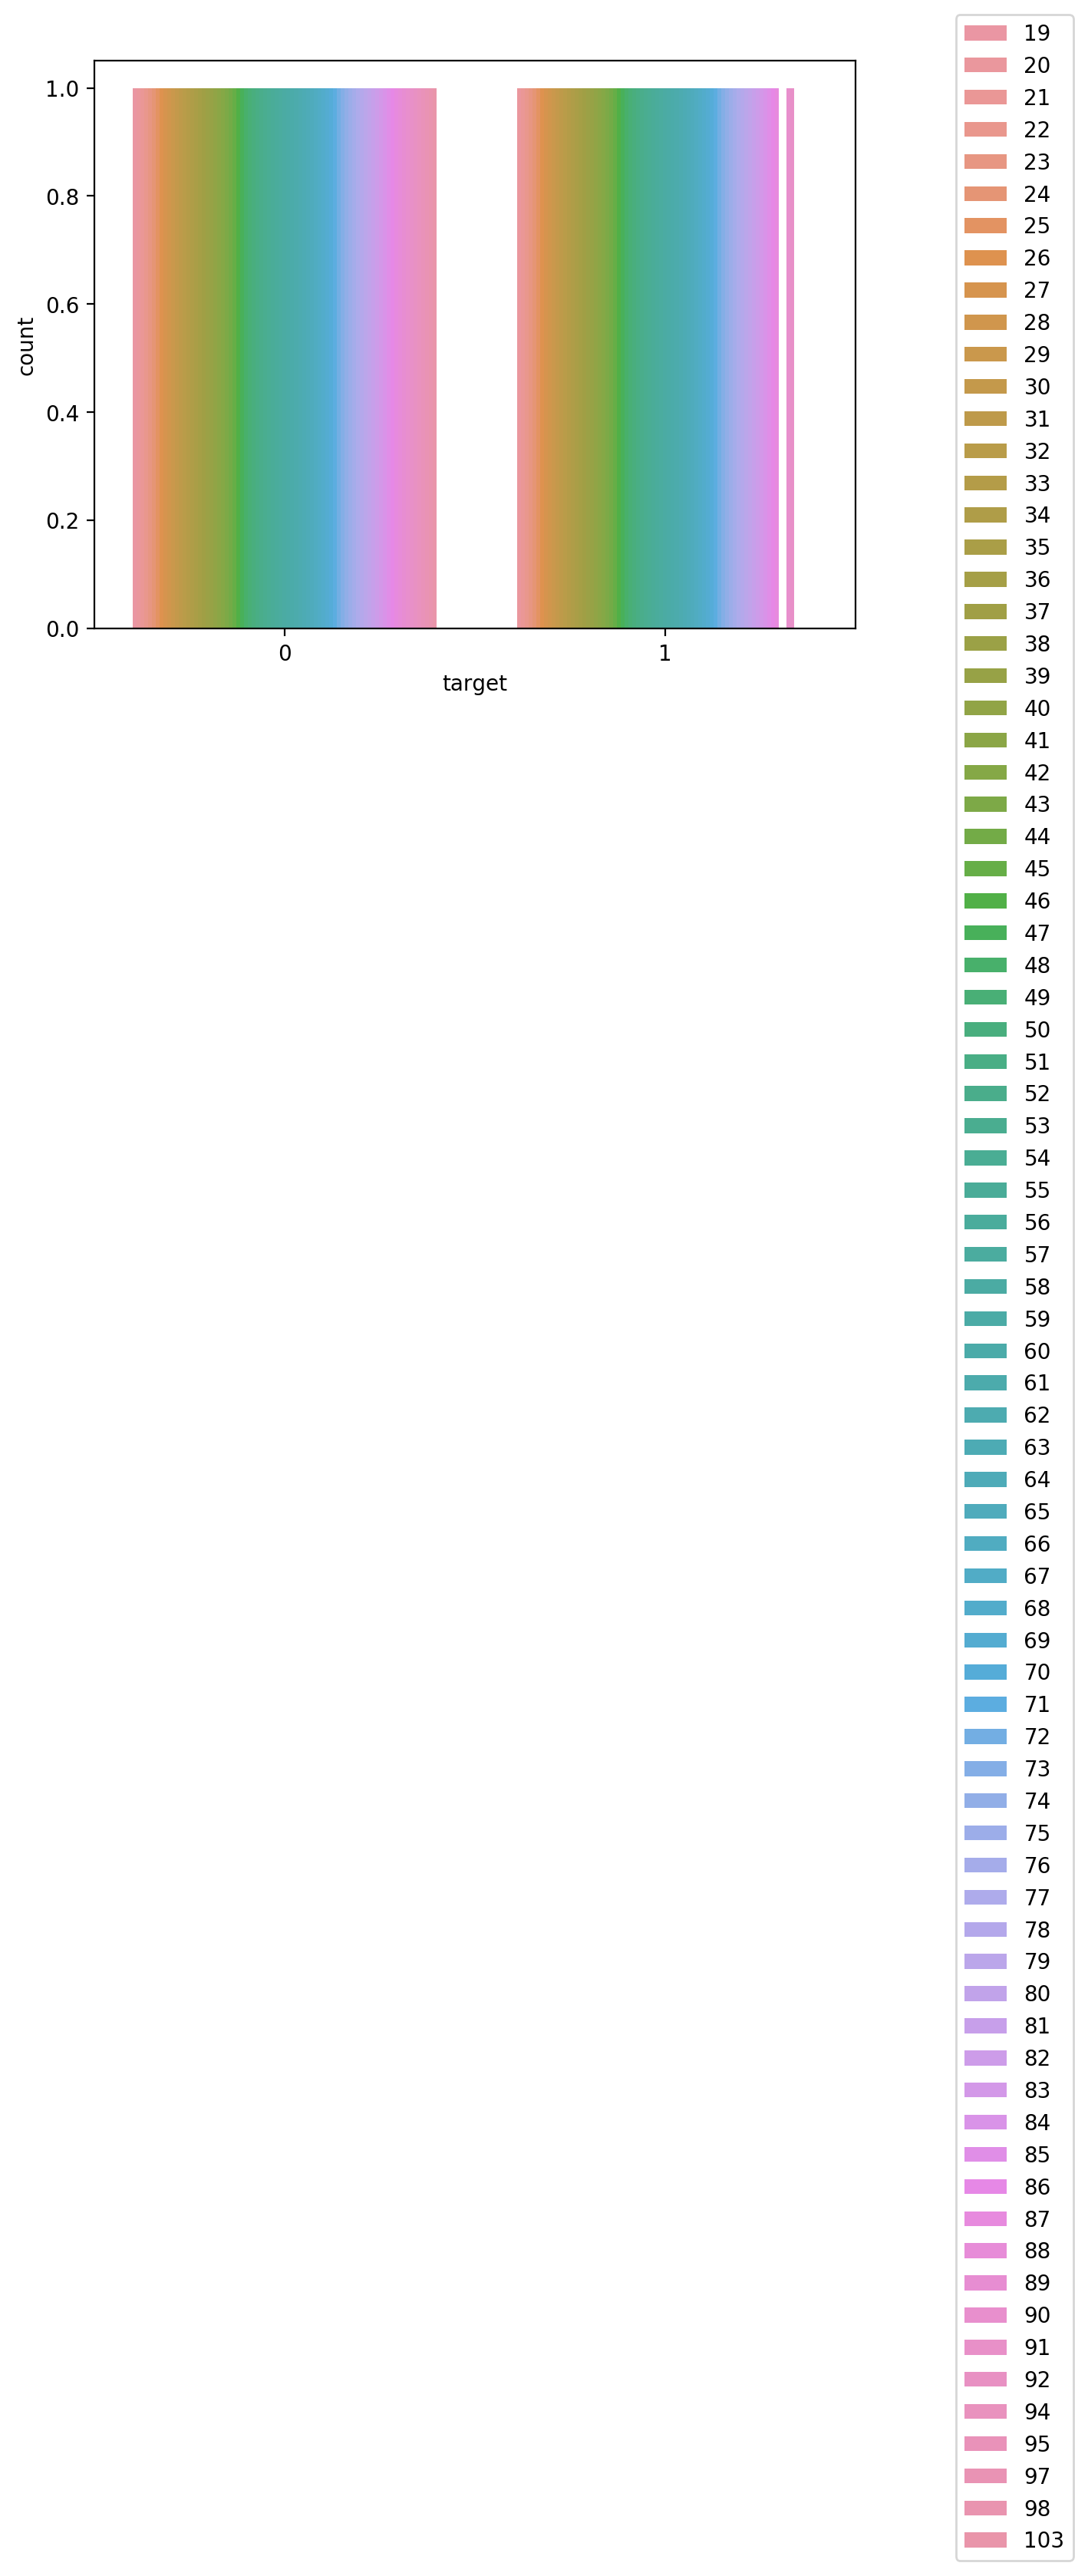

In [32]:
import seaborn as sns

sns.countplot(data=df_balanced, x='target', hue='AGECOND')

plt.legend(loc='upper right',bbox_to_anchor=(1.3, 1.1));

<a name='c1w2-4.'></a>
# 4. Analyze bias on balanced dataset with Amazon SageMaker Clarify
Let's analyze bias in `sentiment` with respect to the `product_category` facet on your balanced dataset.

Save and upload balanced data to S3 bucket.

In [33]:
path_balanced = './data/BASEAUTO_balanced.csv'
df_balanced.to_csv(path_balanced, index=False, header=True)

data_s3_uri_balanced = sess.upload_data(bucket=bucket, key_prefix='bias/balanced', path=path_balanced)
data_s3_uri_balanced

's3://sagemaker-us-east-1-350468654353/bias/balanced/BASEAUTO_balanced.csv'

You can review the uploaded CSV file in the S3 bucket and prefix `bias/balanced`.

In [34]:
from IPython.core.display import display, HTML

display(HTML('<b>Review <a target="top" href="https://s3.console.aws.amazon.com/s3/home?region={}#">Amazon S3 bucket</a></b>'.format(region)))

<a name='c1w2-4.1.'></a>
### 4.1. Configure a `DataConfig`

<a name='c1w2-ex-3'></a>
### Exercise 3

Configure a `DataConfig` for Clarify to analyze bias on the balanced dataset.

**Instructions**: Pass the S3 object path containing the balanced dataset, the path to store the output (`bias_report_balanced_output_path`) and the target column. You can use exercise 1 as an example.

In [37]:
from sagemaker import clarify

bias_report_balanced_output_path = 's3://{}/bias/generated_bias_report/balanced'.format(bucket)

data_config_balanced = clarify.DataConfig(
    ### BEGIN SOLUTION - DO NOT delete this comment for grading purposes
    s3_data_input_path=data_s3_uri_balanced, # Replace None
    s3_output_path=bias_report_balanced_output_path, # Replace None
    label='target', # Replace None
    ### END SOLUTION - DO NOT delete this comment for grading purposes
    headers=df_balanced.columns.to_list(),
    dataset_type='text/csv'
)

<a name='c1w2-4.2.'></a>
### 4.2. Configure `BiasConfig`

`BiasConfig` for the balanced dataset will have the same settings as before.

In [38]:
bias_config_balanced = clarify.BiasConfig(
    label_values_or_threshold=[1], # desired sentiment
    facet_name='AGECOND' # sensitive column (facet)
)

<a name='c1w2-4.3.'></a>
### 4.3. Configure SageMaker Clarify as a processing job

`SageMakerClarifyProcessor` object will also have the same parameters.

In [39]:
clarify_processor_balanced = clarify.SageMakerClarifyProcessor(role=role,
                                                      instance_count=1,
                                                      instance_type='ml.m5.large',
                                                      sagemaker_session=sess)

<a name='c1w2-4.4.'></a>
### 4.4. Run the Amazon SageMaker Clarify processing job

<a name='c1w2-ex-4'></a>
### Exercise 4

Run the configured processing job for the balanced dataset.

**Instructions**: Apply the `run_pre_training_bias` method to the configured Clarify processor, passing the input/output data, configuration of sensitive groups with the other job setup parameters. You can use exercise 2 as an example.


In [40]:
clarify_processor_balanced.run_pre_training_bias(
    ### BEGIN SOLUTION - DO NOT delete this comment for grading purposes
    data_config=data_config_balanced, # Replace None
    data_bias_config=bias_config_balanced, # Replace None
    ### END SOLUTION - DO NOT delete this comment for grading purposes
    methods=["CI", "DPL", "KL", "JS", "LP", "TVD", "KS"],
    wait=False,
    logs=False
)


Job Name:  Clarify-Pretraining-Bias-2023-04-27-18-10-55-955
Inputs:  [{'InputName': 'dataset', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-east-1-350468654353/bias/balanced/BASEAUTO_balanced.csv', 'LocalPath': '/opt/ml/processing/input/data', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}, {'InputName': 'analysis_config', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-east-1-350468654353/bias/generated_bias_report/balanced/analysis_config.json', 'LocalPath': '/opt/ml/processing/input/config', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}]
Outputs:  [{'OutputName': 'analysis_result', 'AppManaged': False, 'S3Output': {'S3Uri': 's3://sagemaker-us-east-1-350468654353/bias/generated_bias_report/balanced', 'LocalPath': '/opt/ml/processing/output', 'S3UploadMode': 'EndOfJob'}}]


In [41]:
run_balanced_bias_processing_job_name = clarify_processor_balanced.latest_job.job_name
print(run_balanced_bias_processing_job_name)

Clarify-Pretraining-Bias-2023-04-27-18-10-55-955


<a name='c1w2-4.5.'></a>
### 4.5. Run and review the Clarify processing job on the balanced dataset
Review the results of the run following the links:

In [42]:
from IPython.core.display import display, HTML

display(HTML('<b>Review <a target="blank" href="https://console.aws.amazon.com/sagemaker/home?region={}#/processing-jobs/{}">processing job</a></b>'.format(region, run_balanced_bias_processing_job_name)))


In [43]:
from IPython.core.display import display, HTML

display(HTML('<b>Review <a target="blank" href="https://console.aws.amazon.com/cloudwatch/home?region={}#logStream:group=/aws/sagemaker/ProcessingJobs;prefix={};streamFilter=typeLogStreamPrefix">CloudWatch logs</a> after about 5 minutes</b>'.format(region, run_balanced_bias_processing_job_name)))


In [44]:
running_processor = sagemaker.processing.ProcessingJob.from_processing_name(processing_job_name=run_balanced_bias_processing_job_name,
                                                                            sagemaker_session=sess)

### _This cell will take approximately 5-10 minutes to run._

In [45]:
%%time

running_processor.wait(logs=False)

.....................................................................*

UnexpectedStatusException: Error for Processing job Clarify-Pretraining-Bias-2023-04-27-18-10-55-955: Failed. Reason: ClientError: Threshold values must be provided for continuous features

<a name='c1w2-4.6.'></a>
### 4.6. Analyze balanced bias report

List the files in the output path `bias_report_balanced_output_path`:

In [49]:
!aws s3 ls $bias_report_balanced_output_path/

2023-04-23 09:10:17      29889 analysis.json
2023-04-23 09:03:58        346 analysis_config.json
2023-04-23 09:10:17    1226587 report.html
2023-04-23 09:10:17     966380 report.ipynb
2023-04-23 09:10:17     834280 report.pdf


Download generated bias report from S3 bucket:

In [50]:
!aws s3 cp --recursive $bias_report_balanced_output_path ./generated_bias_report/balanced/

download: s3://sagemaker-us-east-1-350468654353/bias/generated_bias_report/balanced/analysis_config.json to generated_bias_report/balanced/analysis_config.json
download: s3://sagemaker-us-east-1-350468654353/bias/generated_bias_report/balanced/analysis.json to generated_bias_report/balanced/analysis.json
download: s3://sagemaker-us-east-1-350468654353/bias/generated_bias_report/balanced/report.ipynb to generated_bias_report/balanced/report.ipynb
download: s3://sagemaker-us-east-1-350468654353/bias/generated_bias_report/balanced/report.pdf to generated_bias_report/balanced/report.pdf
download: s3://sagemaker-us-east-1-350468654353/bias/generated_bias_report/balanced/report.html to generated_bias_report/balanced/report.html


Review the downloaded bias report (in HTML format):

In [51]:
from IPython.core.display import display, HTML

display(HTML('<b>Review <a target="blank" href="./generated_bias_report/balanced/report.html">balanced bias report</a></b>'))

In this run, you analyzed bias for `sentiment` relative to the `product_category` for the balanced data.  Note that the Class Imbalance (CI) metric is equal across all product categories for the target label, `sentiment`. And Difference in Positive Proportions in Labels (DPL) metric values are zero.

Upload the notebook into S3 bucket for grading purposes.

**Note**: you may need to click on "Save" button before the upload.

In [ ]:
!aws s3 cp ./C1_W2_Assignment.ipynb s3://$bucket/C1_W2_Assignment_Learner.ipynb

Please go to the main lab window and click on `Submit` button (see the `Finish the lab` section of the instructions).